<a href="https://colab.research.google.com/github/clive-limo/DataScienceProjects/blob/main/white_blood_cells_resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

In [ ]:
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import numpy as np
import os.path
from pathlib import Path
import glob
import pandas as pd
import random
from fastai.vision.all import *
import fastai as fa
from fastai import losses

In [ ]:
disease_classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']#name of the classes
num_classes = len(disease_classes)
image_size = (120,120)#resizing the size of image to be fed to the network

In [ ]:
train_pth = Path('/content/dataset2-master/dataset2-master/images/TRAIN')
test_pth = Path('/content/dataset2-master/dataset2-master/images/TEST')

In [ ]:
train_imgs_path = list(train_pth.glob(r"**/*.jpeg"))
test_imgs_path = list(test_pth.glob(r"**/*.jpeg"))

In [ ]:
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_imgs_path))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_imgs_path))

In [ ]:
train_df = pd.DataFrame()
train_df['img_path'] = train_imgs_path
train_df['label'] = train_labels
train_df.head(2)

,img_path,label


In [ ]:
test_df = pd.DataFrame()
test_df['img_path'] = test_imgs_path
test_df['label'] = test_labels
test_df.head(2)

,img_path,label


In [ ]:
def get_x(r):
    return r['img_path']

def get_y(r):
    return r['label']

In [ ]:
def get_data(size=224,bs=128,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=get_x, 
                       get_y=get_y,
                       item_tfms = RandomResizedCrop(460),
                       batch_tfms = [*aug_transforms(size=size),Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

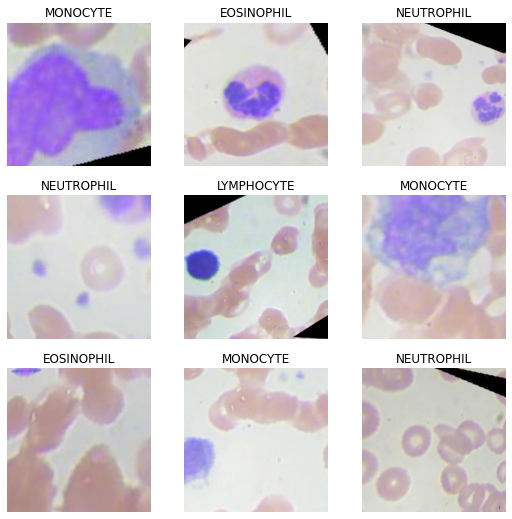

In [ ]:
dls = get_data()
dls.show_batch()

In [ ]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet34/resnet34-333f7ec4.pth' '/root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth'

cp: cannot stat '../input/resnet34/resnet34-333f7ec4.pth': No such file or directory


In [ ]:
loss_func = losses.LabelSmoothingCrossEntropy()
cbs = MixUp

In [ ]:
learn = cnn_learner(dls, resnet34, loss_func=loss_func, metrics=accuracy, cbs=cbs)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0030199517495930195)

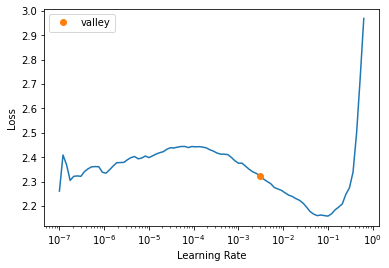

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(20, freeze_epochs=8, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.003, patience=3))

epoch,train_loss,valid_loss,accuracy,time
0,2.186856,1.353812,0.424410,48:43
1,1.964300,1.139071,0.558513,48:40
2,1.765929,0.999879,0.647916,48:28
3,1.611166,0.948693,0.672526,48:32


epoch,train_loss,valid_loss,accuracy,time
0,2.186856,1.353812,0.424410,48:43
1,1.964300,1.139071,0.558513,48:40
2,1.765929,0.999879,0.647916,48:28
3,1.611166,0.948693,0.672526,48:32
4,1.410879,0.875439,0.722752,48:43
5,1.273026,0.827550,0.772476,48:50


In [ ]:
test_df.head(2)

In [ ]:
test_data_path = test_df['img_path'].apply(lambda x: x)
tst_dl = learn.dls.test_dl(test_data_path)
predictions = learn.tta(dl = tst_dl, n=10)
predicted_labels = np.argmax(predictions[0],axis=1)
predicted_labels

In [ ]:
le = LabelEncoder()
enc_targ = le.fit_transform(test_df['label'])
resnet_accuracy = accuracy_score(enc_targ, predicted_labels)
print("Model accuracy: " + str(resnet_accuracy))

In [ ]:
accuracy_score()